# Proyecto Final Bioestadística

### Grupo 02
* Martín Cortés Albarracín - 202313528
* Hassan Eisa Cavieles Eljadue - 
* Sara Ximena Arias - 202


## Importamos librerías

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
from __future__ import annotations   
from itertools import product  
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import bootstrap
from scipy.spatial import distance
from numpy.linalg import inv
from scipy.stats import chi2
from normalizato_utile import *

## Manejo que se hizo con el DataFrame original

* Se categorizó la variable MMSE de la siguiente manera:
    * 30-27 puntos: Sin deterioro
    * 26-25 puntos: Dudoso o posible deterioro
    * 24-10 puntos: Deterioro leve a moderado
    * 9-6 puntos: Demencia moderada a severa
    * Menos de 6 puntos: Demencia severa.
* Se categorizó la variable AGE en la siguiente manera:
    * 60-69 años
    * 70-79 años
    * 80-90 años


In [2]:
df = pd.read_csv("Dataset_G2.csv")
pos = 0
# Agrupamiento de edades
for data in df["Age"]:
    if data < 70:
        df["Age"][pos] = "60-69"
    elif data >= 70 and data < 80:
        df["Age"][pos] = "70-79"
    elif data >= 80 and data <= 90:
        df["Age"][pos] = "80-90"
    pos += 1
df["Age"] = df["Age"].astype("category")

# Agrupamiento de MMSE
pos = 0
for data in df["MMSE"]:
    if data >= 27:
        df["MMSE"][pos] = "Sin deterioro"
    elif data >= 25 and data < 27:
        df["MMSE"][pos] = "Posible deterioro"
    elif data >= 10 and data < 25:
        df["MMSE"][pos] = "Deterioro leve"
    elif data >= 6 and data < 10:
        df["MMSE"][pos] = "Deterioro moderado"
    elif data < 6:
        df["MMSE"][pos] = "Demencia severa"
    pos += 1
df["MMSE"] = df["MMSE"].astype("category")
print(df["Age"].value_counts())
print(df["MMSE"].value_counts())

#Eliminar filas con datos faltantes
#print(len(df))
#df = df.dropna()
#print(len(df))
#print(df["Age"].value_counts())
#print(df["MMSE"].value_counts())
#df.to_csv(Path("Datos_Proyecto_Final.csv", index=False))

C:\Users\user\AppData\Local\Temp\ipykernel_18940\275944412.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Age"][pos] = "70-79"
C:\Users\user\AppData\Local\Temp\ipykernel_18940\275944412.py:8: SettingWithCopyWarning: 
A value is tryi

Age
80-90    88980
70-79    81101
60-69    80856
Name: count, dtype: int64
MMSE
Deterioro leve        125082
Demencia severa        50317
Deterioro moderado     33688
Sin deterioro          25041
Posible deterioro      16809
Name: count, dtype: int64


## Parte 1: Manejo de datos

#### Carga de datos

In [3]:
df=pd.read_csv("Datos_G2.csv")
#df = df.dropna() -> si hacemos dropna, perdemos demasiados datos (quedamos solo con 1400 filas aprox)
print(df["LocationDesc"].unique())
print(len(df))


['West' 'Northeast' 'Midwest' 'Idaho' 'Louisiana' 'Massachusetts'
 'Maryland' 'New Mexico' 'Ohio' 'Oregon' 'South Carolina' 'South'
 'Wisconsin' 'Tennessee' 'New Hampshire' 'Kansas' 'Utah' 'Rhode Island'
 'Michigan' 'Washington' 'Virginia' 'Arizona' 'Mississippi' 'Montana'
 'West Virginia' 'Missouri' 'Vermont' 'Pennsylvania' 'North Carolina'
 'New Jersey' 'Arkansas' 'Hawaii' 'Connecticut' 'Minnesota' 'Texas'
 'Nebraska' 'New York' 'Maine' 'Alaska' 'Georgia' 'Indiana' 'Kentucky'
 'North Dakota' 'Oklahoma' 'Wyoming' 'District of Columbia' 'Iowa'
 'Alabama' 'South Dakota' 'Illinois' 'Colorado' 'Nevada' 'California'
 'Delaware']
2149


#### Variables

In [4]:
categoricas = ["Age","Gender","MMSE","LocationDesc"]
numericas = ["Data_Value","CholesterolLDL"]

#### Histogramas

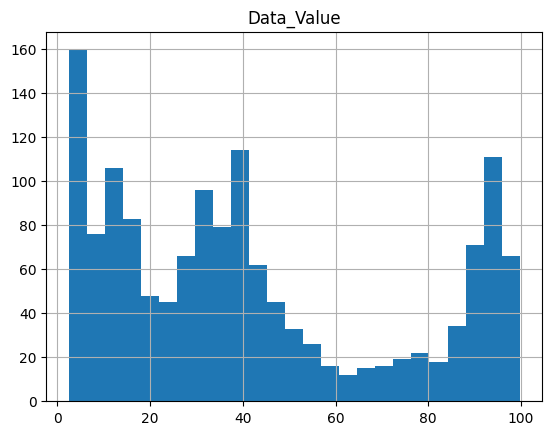

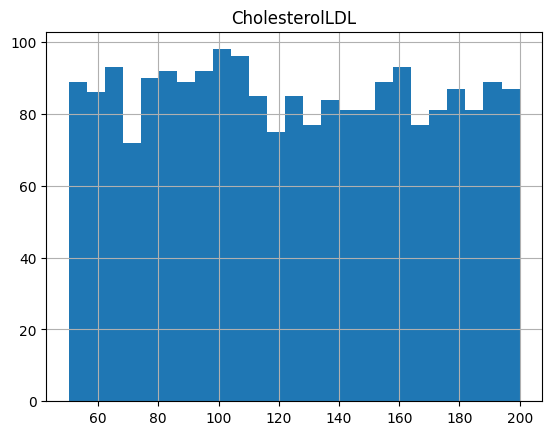

In [5]:
#[df[c].hist(bins=round(np.sqrt(len(df)))) for c in columns_interes]; plt.show()
for col in numericas:
  #df[col].hist(bins=round(np.sqrt(len(df)))); plt.title(col); plt.show()
  df[col].hist(bins=25); plt.title(col); plt.show()

#### Normalizado

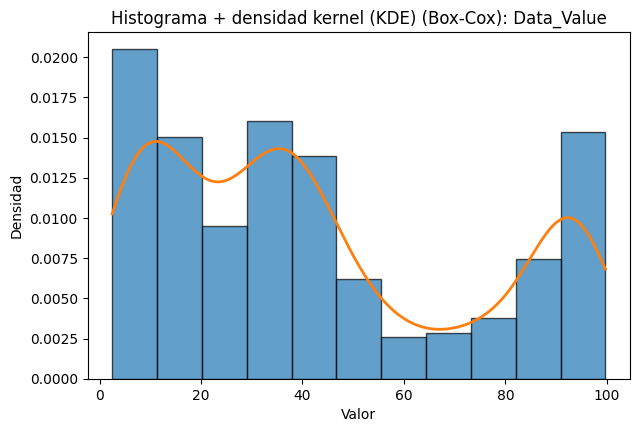

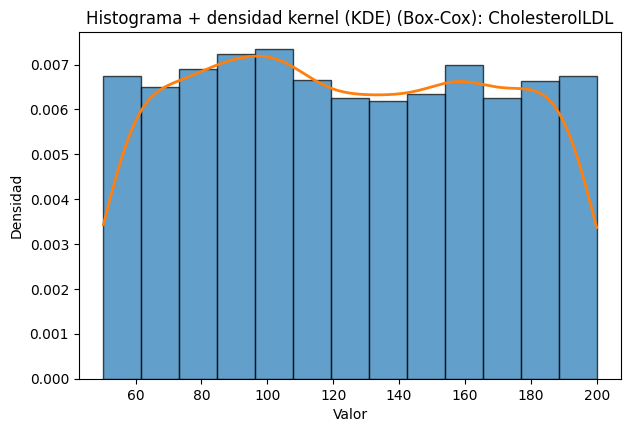

In [6]:
for col in numericas:
    columna = df[col].dropna()  # Remove NaNs
    plt.figure(figsize=(7,4.5))
    plt.hist(columna, bins="fd", density=True, alpha=0.7, edgecolor="black")
    kde = stats.gaussian_kde(columna)
    xs = np.linspace(columna.min(), columna.max(), 400)
    plt.plot(xs, kde(xs), linewidth=2)
    plt.title(f"Histograma + densidad kernel (KDE) (Box-Cox): {col}")
    plt.xlabel("Valor"); plt.ylabel("Densidad")
    plt.show()

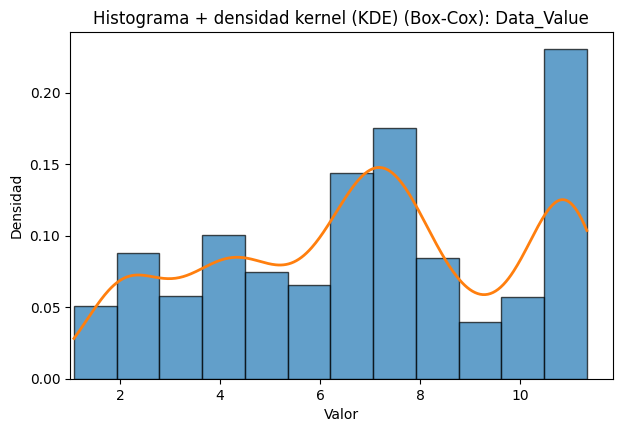

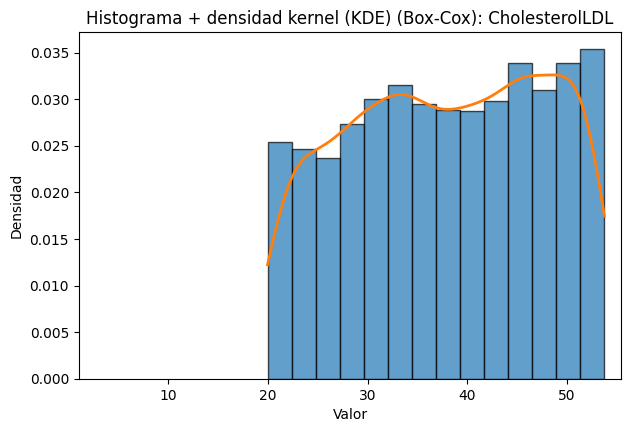

In [7]:
# ===== 1) Histograma + KDE =====
for col in numericas:
    columna = df[col].dropna()  # Remove NaNs

    min_val = np.min(columna)
    # Si el valor mínimo es menor o igual a 0, trasladamos los datos
    if min_val <= 0:
      shift_value = abs(min_val) + 1  # Trasladamos los datos para que todos sean positivos
      columna += shift_value
    columna_box_cox, lambda_ = stats.boxcox(columna)
    plt.figure(figsize=(7,4.5))
    plt.hist(columna_box_cox, bins="fd", density=True, alpha=0.7, edgecolor="black")
    plt.xlim(1)
    kde = stats.gaussian_kde(columna_box_cox)
    xs = np.linspace(columna_box_cox.min(), columna_box_cox.max(), 400)
    plt.plot(xs, kde(xs), linewidth=2)
    plt.title(f"Histograma + densidad kernel (KDE) (Box-Cox): {col}")
    plt.xlabel("Valor"); plt.ylabel("Densidad")
    plt.show()
    print("\n")


#### Scatter Plots

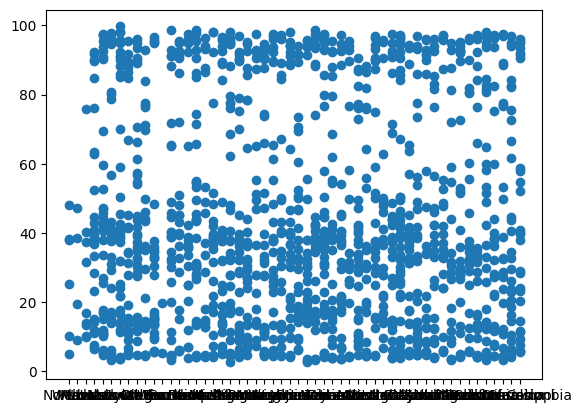

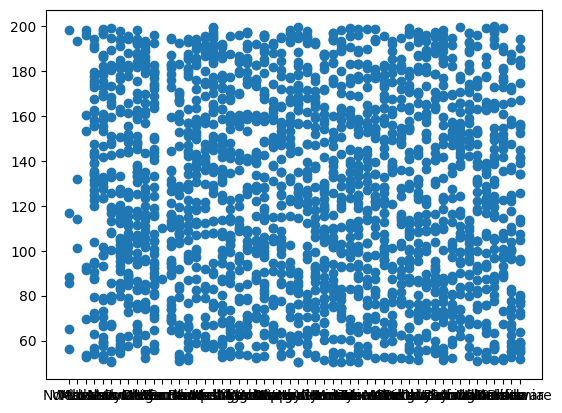

In [8]:
for c in numericas:
    num = df[["LocationDesc", c]].dropna()

    plt.scatter(num.iloc[:,0], num.iloc[:,1]); plt.show() 

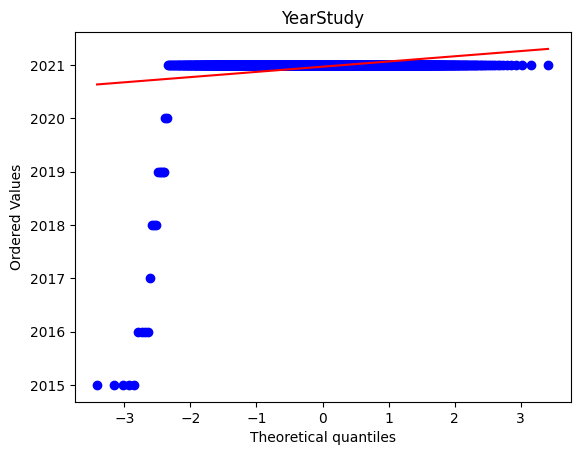

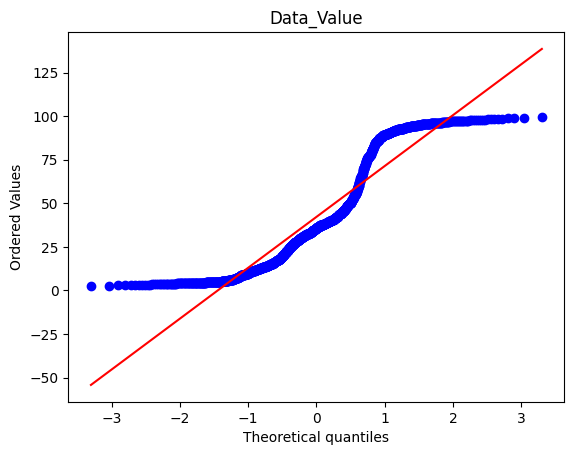

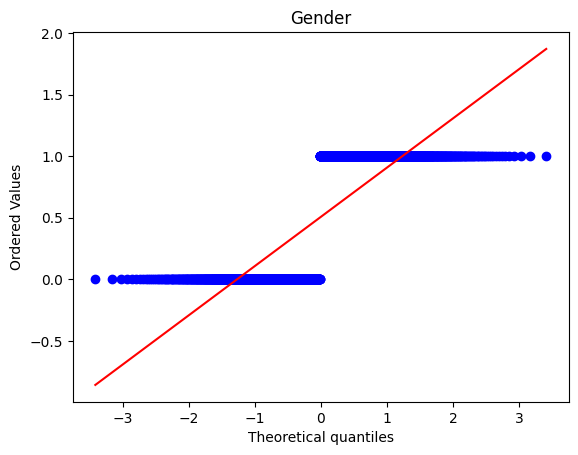

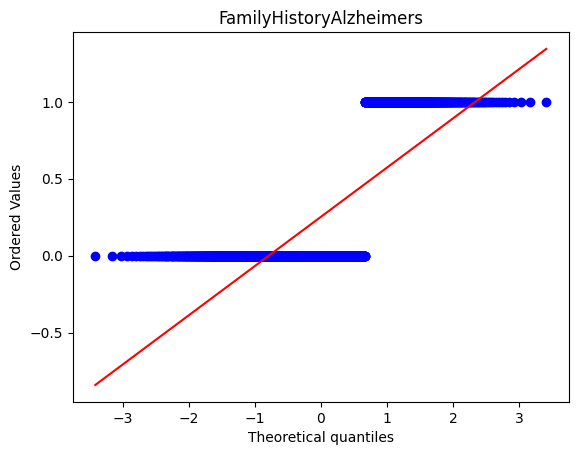

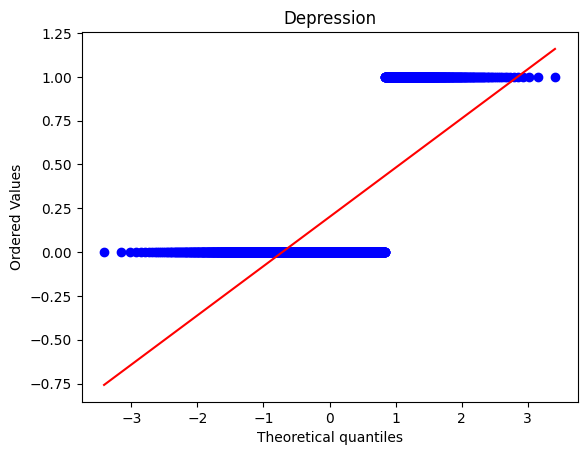

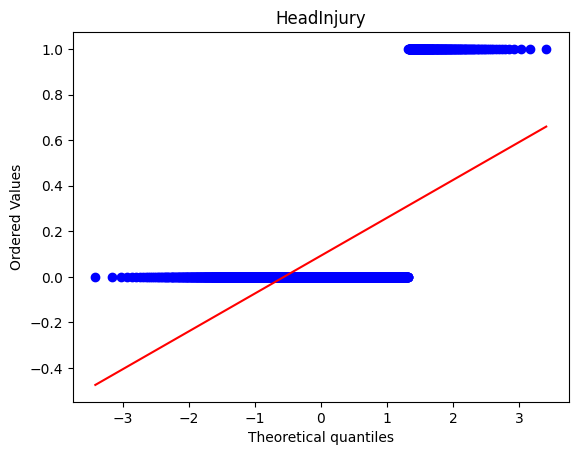

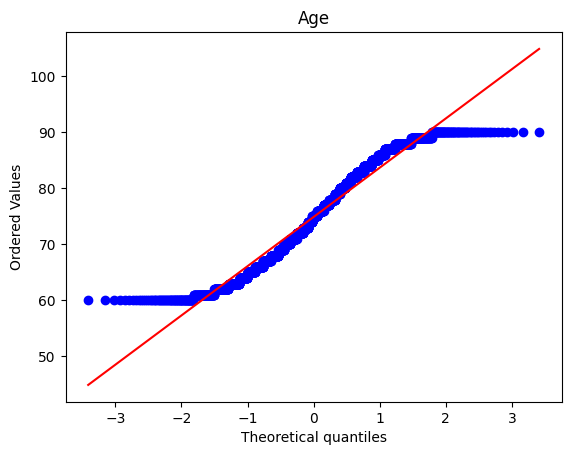

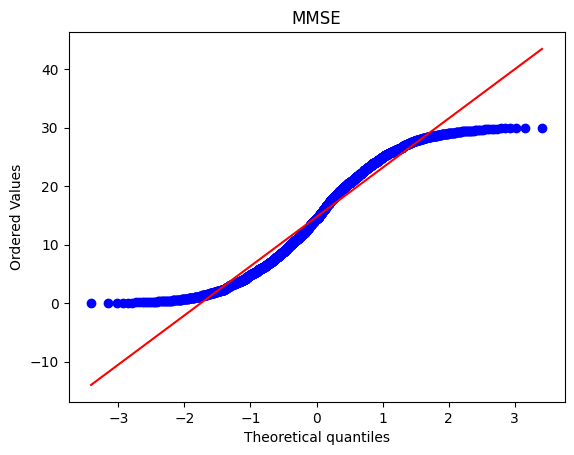

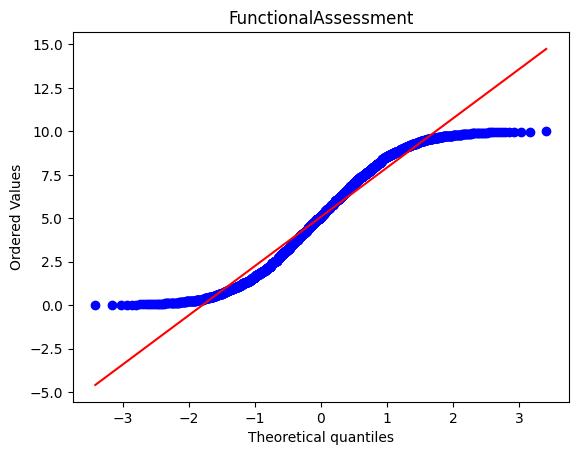

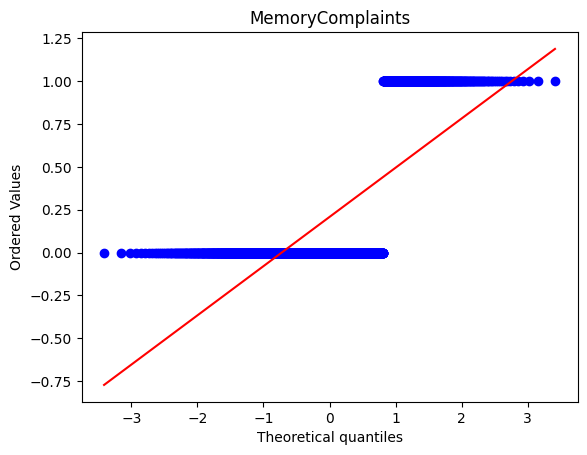

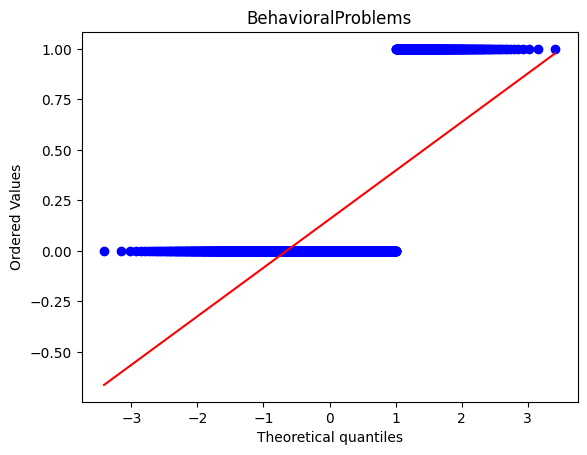

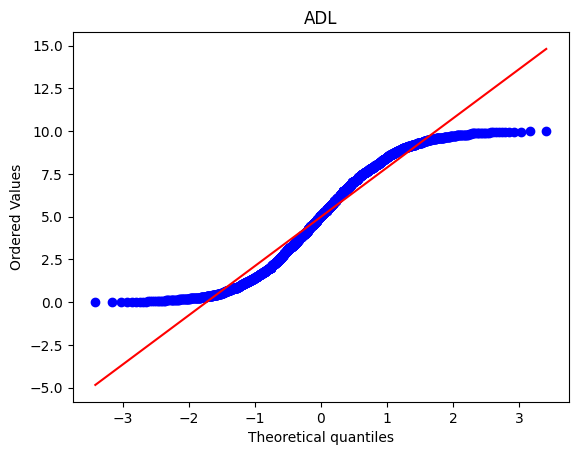

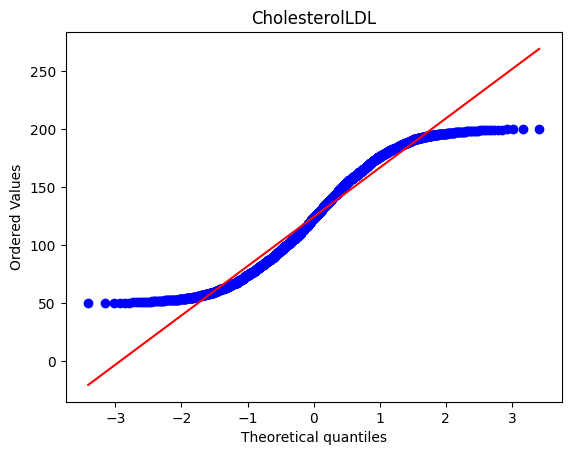

In [9]:
for col in df.select_dtypes(include="number").columns:
  if "name" not in col: #Para que no salga la columna que se llama "Unnamed" que corresponde al índice de cada fila.
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(col); plt.show()

## MANOVA

In [10]:
# Eliminar filas con valores nulos en la columna Data_Value
df_cleaned = df.dropna(subset=['Data_Value'])

# Fórmula simplificada
formula = "Data_Value + CholesterolLDL ~ C(Age) + C(MMSE) + C(LocationDesc) + C(Gender)"

# Ejecutar el análisis MANOVA
manova = MANOVA.from_formula(formula, data=df_cleaned)
mv_out = manova.mv_test()
print(mv_out)


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\multivariate\multivariate_ols.py:196: RuntimeWarning: invalid value encountered in power
  lmd = np.power(lmd, 1 / t)


                                 Multivariate linear model
                                                                                            
---------------------------------------------------------------------------------------------
        Intercept                Value         Num DF   Den DF         F Value         Pr > F
---------------------------------------------------------------------------------------------
           Wilks' lambda              -0.0000  2.0000  -85.0000  189896325052817.7500     nan
          Pillai's trace               1.0020  2.0000  -85.0000            20820.5110     nan
  Hotelling-Lawley trace  -4459009532050.9941  2.0000  -42.5000   94753952556083.6250     nan
     Roy's greatest root               0.0020  2.0000  -85.0000               -0.0871     nan
--------------------------------------------------------------------------------------------
                                                                                            
----

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\multivariate\multivariate_ols.py:196: RuntimeWarning: invalid value encountered in power
  lmd = np.power(lmd, 1 / t)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\multivariate\multivariate_ols.py:196: RuntimeWarning: invalid value encountered in power
  lmd = np.power(lmd, 1 / t)


## ANOVA de una vía

In [12]:
residuos = smf.ols('CholesterolLDL ~ C(Age)*C(MMSE)*C(LocationDesc)*C(Gender)', data=df).fit().resid
#print(residuos) #Solamente números

#Q-Q
stats.probplot(residuos, dist="norm", plot=plt); plt.show()

#Hist
residuos.hist(bins=round(np.sqrt(len(residuos)))); plt.show()

MemoryError: Unable to allocate 115. GiB for an array with shape (2149, 7194852) and data type float64

In [ ]:
print(stats.shapiro(residuos))
assert stats.shapiro(residuos).pvalue > 0.05, "Se rechaza la normalidad."

ShapiroResult(statistic=np.float64(0.9841762748761328), pvalue=np.float64(1.0471958579125542e-14))


AssertionError: Se rechaza la normalidad.

In [ ]:
df["Celda"] = df["Age"].astype(str) + "|" + df["LocationDesc"].astype(str) + "|" + df["MMSE"].astype(str)
#df['Celda'] = df['Celda'].astype('category')
pg.homoscedasticity(data=df, dv='CholesterolLDL', group='Celda', method='levene')

,W,pval,equal_var
levene,NaN,NaN,False


### Age

In [ ]:
print(df['Age'].unique())

# ANOVA
print("\n\nANOVA")
anovita = pg.anova(dv='CholesterolLDL', between=['Age'], data=df, detailed=True)
print(anovita)

# Post-hoc (Tukey)
print("\n\nPost-hoc (Tukey)")
tukey_results = pg.pairwise_tukey(dv='CholesterolLDL', between='Age', data=df) 
print(tukey_results)

['70-79', '80-90', '60-69']
Categories (3, object): ['60-69', '70-79', '80-90']


ANOVA
   Source            SS    DF           MS         F     p-unc      np2
0     Age  9.681776e+02     2   484.088785  0.257226  0.773218  0.00024
1  Within  4.038691e+06  2146  1881.962171       NaN       NaN      NaN


Post-hoc (Tukey)
       A      B     mean(A)     mean(B)      diff        se         T  \
0  60-69  70-79  124.083642  123.645617  0.438025  2.315540  0.189168   
1  60-69  80-90  124.083642  125.224755 -1.141113  2.282719 -0.499892   
2  70-79  80-90  123.645617  125.224755 -1.579138  2.281045 -0.692287   

    p-tukey    hedges  
0  0.980466  0.009928  
1  0.871368 -0.026351  
2  0.768026 -0.036895  


####

### MMSE

In [ ]:
print(df["MMSE"].unique())
pg.anova(dv='CholesterolLDL', between=['MMSE'], data=df, detailed=True)

# Post-hoc (Tukey)
pg.pairwise_tukey(dv='CholesterolLDL', between='MMSE', data=df) 

['Deterioro leve', 'Deterioro moderado', 'Sin deterioro', 'Demencia severa', 'Posible deterioro']
Categories (5, object): ['Demencia severa', 'Deterioro leve', 'Deterioro moderado', 'Posible deterioro', 'Sin deterioro']


,Source,SS,DF,MS,F,p-unc,np2
0,MMSE,7.630386e+03,4,1907.596582,1.01435,0.398553,0.001889
1,Within,4.032029e+06,2144,1880.610359,NaN,NaN,NaN


### LocationDesc

In [ ]:
print(df["LocationDesc"].unique())
pg.anova(dv='CholesterolLDL', between=['LocationDesc'], data=df, detailed=True)
# Post-hoc (Tukey)
pg.pairwise_tukey(dv='CholesterolLDL', between='LocationDesc', data=df) 

['West' 'Northeast' 'Midwest' 'Idaho' 'Louisiana' 'Massachusetts'
 'Maryland' 'New Mexico' 'Ohio' 'Oregon' 'South Carolina' 'South'
 'Wisconsin' 'Tennessee' 'New Hampshire' 'Kansas' 'Utah' 'Rhode Island'
 'Michigan' 'Washington' 'Virginia' 'Arizona' 'Mississippi' 'Montana'
 'West Virginia' 'Missouri' 'Vermont' 'Pennsylvania' 'North Carolina'
 'New Jersey' 'Arkansas' 'Hawaii' 'Connecticut' 'Minnesota' 'Texas'
 'Nebraska' 'New York' 'Maine' 'Alaska' 'Georgia' 'Indiana' 'Kentucky'
 'North Dakota' 'Oklahoma' 'Wyoming' 'District of Columbia' 'Iowa'
 'Alabama' 'South Dakota' 'Illinois' 'Colorado' 'Nevada' 'California'
 'Delaware' 'United States, DC & Territories' 'Virgin Islands'
 'Puerto Rico' 'Guam' 'Florida']


,Source,SS,DF,MS,F,p-unc,np2
0,LocationDesc,7.165060e+04,53,1351.898189,0.713765,0.940946,0.017737
1,Within,3.968008e+06,2095,1894.037418,NaN,NaN,NaN


### Gender

In [ ]:
print(df["Gender"].unique())
pg.anova(dv='CholesterolLDL', between=['Gender'], data=df, detailed=True)
## Post-hoc (Tukey)
pg.pairwise_tukey(dv='CholesterolLDL', between='Gender', data=df) 

[0 1]


## Post-hoc (Tukey)

¿Este tukey lo hago individual para cada ANOVA? o lo hago así con la celda para todos (aunque no creo, porque antes hicimos anova individual...)

Si estuvo bien hacer anova individual? de una vía para cada uno?

O era mejor hacer ANOVA de varias vías...

In [ ]:
pg.pairwise_tukey(dv='CholesterolLDL', between='Celda', data=df) #Siempre es la celda, no cada columna por separado

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\pairwise.py:886: RuntimeWarning: divide by zero encountered in divide
  gvar = aov.at[1, "MS"] / n
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\effsize.py:803: RuntimeWarning: Mean of empty slice.
  d = (x.mean() - y.mean()) / poolsd
c:\Users\user\AppD

KeyboardInterrupt: 

## PCA

#### Ejemplo de la clase (No tocar código... usarlo como template copiando y pegando ⚠)

🔬 Análisis PCA para Datos Biomédicos
📊 Dataset: 569 muestras, 30 características
📈 Características: mean radius, mean texture, mean perimeter, mean area, mean smoothness...
🎯 Clases: ['malignant' 'benign']

🔧 Datos normalizados (media=0, std=1)
Media después de normalización: -0.000000
Desviación estándar: 1.000000

🧮 PCA Resultados:
Componentes necesarios para 95% varianza: 10
Reducción dimensional: 30 → 10
Varianza explicada total: 0.952

📊 Varianza explicada por componente:
PC1: 0.443 (44.3%)

📈 Varianza acumulada primeros 3 PCs: 0.726
PC2: 0.190 (19.0%)

📈 Varianza acumulada primeros 3 PCs: 0.726
PC3: 0.094 (9.4%)

📈 Varianza acumulada primeros 3 PCs: 0.726
PC4: 0.066 (6.6%)

📈 Varianza acumulada primeros 3 PCs: 0.726
PC5: 0.055 (5.5%)

📈 Varianza acumulada primeros 3 PCs: 0.726


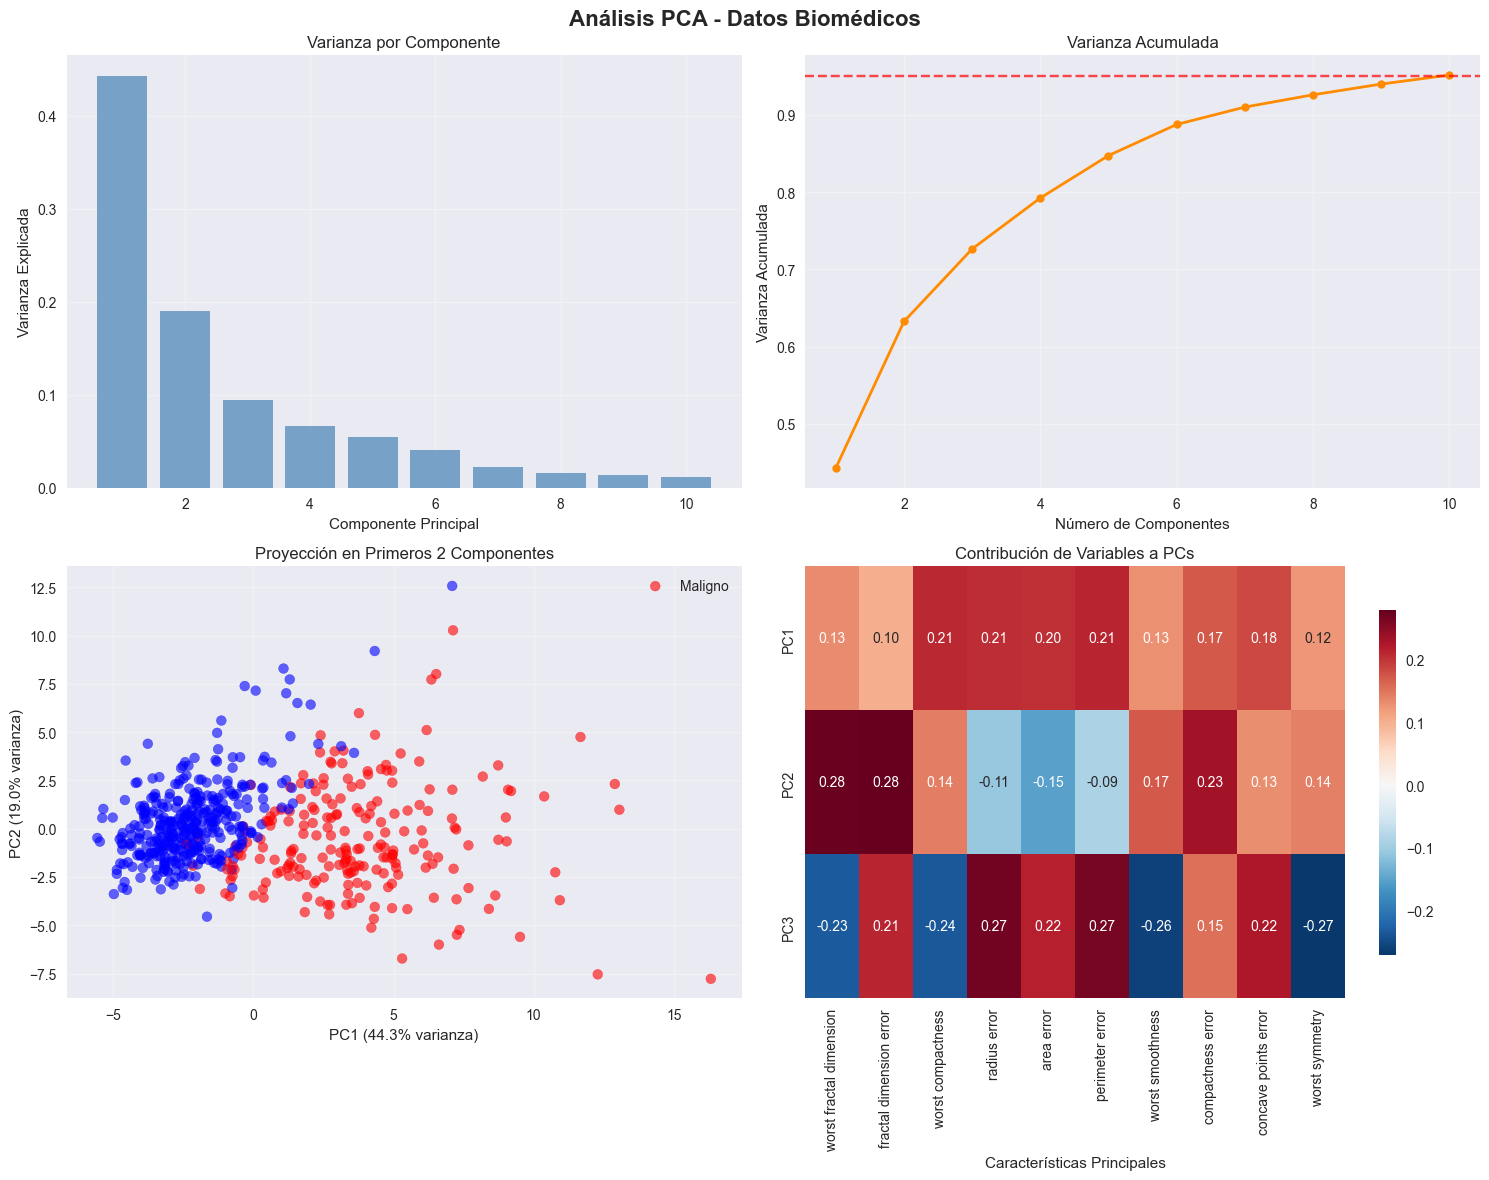

In [ ]:
# Importar librerías necesarias 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn.datasets import load_breast_cancer 

# Configurar estilo de gráficos 
plt.style.use('seaborn-v0_8') 
sns.set_palette("husl") 
print("🔬 Análisis PCA para Datos Biomédicos") 
print("="*50)

# 1. CARGAR Y PREPARAR DATOS 
# Usaremos el dataset de cáncer de mama de Wisconsin (569 muestras, 30 características) 
data = load_breast_cancer() 
X = data.data 
y = data.target 
feature_names = data.feature_names 
target_names = data.target_names 

# Crear DataFrame para mejor manejo 
df = pd.DataFrame(X, columns=feature_names) 
df['diagnosis'] = y 
print(f"📊 Dataset: {X.shape[0]} muestras, {X.shape[1]} características") 
print(f"📈 Características: {', '.join(feature_names[:5])}...") 
print(f"🎯 Clases: {target_names}")

# 2. NORMALIZACIÓN DE DATOS 
# PCA es sensible a la escala, por eso normalizamos 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
print("\n🔧 Datos normalizados (media=0, std=1)") 
print(f"Media después de normalización: {np.mean(X_scaled):.6f}") 
print(f"Desviación estándar: {np.std(X_scaled):.6f}")

# 3. APLICAR PCA 
# Inicializar PCA para conservar 95% de la varianza 
pca = PCA(n_components=0.95) 
# Mantener 95% de varianza explicada 

X_pca = pca.fit_transform(X_scaled) 
print(f"\n🧮 PCA Resultados:") 
print(f"Componentes necesarios para 95% varianza: {pca.n_components_}") 
print(f"Reducción dimensional: {X.shape[1]} → {X_pca.shape[1]}") 
print(f"Varianza explicada total: {pca.explained_variance_ratio_.sum():.3f}")

# 4. ANÁLISIS DE COMPONENTES PRINCIPALES 
# Varianza explicada por cada componente 

explained_var = pca.explained_variance_ratio_ 
cumulative_var = np.cumsum(explained_var) 
# Mostrar primeros 5 componentes 
print(f"\n📊 Varianza explicada por componente:") 
for i in range(min(5, len(explained_var))): 
    print(f"PC{i+1}: {explained_var[i]:.3f} ({explained_var[i]*100:.1f}%)") 
    print(f"\n📈 Varianza acumulada primeros 3 PCs: {cumulative_var[2]:.3f}")

# 5. VISUALIZACIÓN
# Configurar subplot 
fig, axes = plt.subplots(2, 2, figsize=(15, 12)) 
fig.suptitle('Análisis PCA - Datos Biomédicos', fontsize=16, fontweight='bold') 
# 1. Varianza explicada 
axes[0,0].bar(range(1, min(11, len(explained_var)+1)), explained_var[:min(10, len(explained_var))], alpha=0.7, color='steelblue') 
axes[0,0].set_xlabel('Componente Principal') 
axes[0,0].set_ylabel('Varianza Explicada') 
axes[0,0].set_title('Varianza por Componente') 
axes[0,0].grid(True, alpha=0.3) 
# 2. Varianza acumulada 
axes[0,1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'o-', color='darkorange', linewidth=2, markersize=6) 
axes[0,1].axhline(y=0.95, color='red', linestyle='--', alpha=0.7) 
axes[0,1].set_xlabel('Número de Componentes') 
axes[0,1].set_ylabel('Varianza Acumulada') 
axes[0,1].set_title('Varianza Acumulada') 
axes[0,1].grid(True, alpha=0.3) 
# 3. Proyección 2D (PC1 vs PC2) 
colors = ['red' if label == 0 else 'blue' for label in y] 
axes[1,0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, s=50) 
axes[1,0].set_xlabel(f'PC1 ({explained_var[0]:.1%} varianza)') 
axes[1,0].set_ylabel(f'PC2 ({explained_var[1]:.1%} varianza)') 
axes[1,0].set_title('Proyección en Primeros 2 Componentes') 
axes[1,0].legend(['Maligno', 'Benigno']) 
axes[1,0].grid(True, alpha=0.3) 
# 4. Heatmap de componentes principales 
# Mostrar contribution de variables originales a primeros 3 PCs 
components_df = pd.DataFrame( pca.components_[:3], columns=feature_names, index=['PC1', 'PC2', 'PC3'] ) 
# Seleccionar top 10 características más importantes 
importance = np.abs(components_df).sum(axis=0).sort_values(ascending=False) 
top_features = importance.head(10).index 
sns.heatmap(components_df[top_features], annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1,1], cbar_kws={'shrink': 0.8}) 
axes[1,1].set_title('Contribución de Variables a PCs') 
axes[1,1].set_xlabel('Características Principales') 
plt.tight_layout() 
plt.show()

#### Nuestro caso (aplicado aData value en función de LocationDesc)

🔬 Análisis PCA para Datos Biomédicos
📊 Dataset: 1439 muestras, 6 características
📈 Características: Data_Value, Age, MMSE, ADL, CholesterolLDL...
🎯 Clases: [array([38.1, 19.5, 16.8,  4.9, 40.2, 48.2, 75.7, 13.3, 63.5, 25.6, 38. ,
       15.2,  5.3,  4. , 32. , 45.5, 34.4,  8.9, 47.2, 57.3, 43.3, 48.3,
       19.6,  5.1,  9.9, 37.8, 10.1,  9. , 15. , 12. , 13.7, 12.8, 25.1,
       37.3, 47.3, 14. , 10.2, 21.6, 88.9, 11.4, 40.4, 40.6,  nan, 95.6,
       10.5,  6.8, 47. , 37.7, 11.9, 39.7, 37.6, 96.1, 49.5, 99.7, 28.7,
       12.4,  4.6, 20.3, 17. , 36.8, 17.3, 93.9, 42.9, 32.5, 31.1, 90.9,
       55.4, 80.7, 45.1, 17.1,  4.2, 75.9, 11.8, 36.9, 94.3,  4.3, 39.3,
       65.2, 26.8, 94.6, 33.5, 42.2,  4.7, 14.9, 89.6, 44.9, 29.1, 22.8,
       28.1, 92.5, 18.1, 35.2,  4.8, 28.8, 96.9, 38.6, 70.7, 91.1, 94.1,
       92.8, 49.4, 91.2, 88.3, 24. , 18.2,  6.5, 13.1, 25.3, 46.7,  9.3,
       62.7, 77.5,  5.5, 41.7,  3.6, 16.7, 52.9, 75.3, 39.2, 38.4, 44. ,
       50.1,  5.6, 90.3, 36.5, 92.7, 12.

ValueError: Shape of passed values is (3, 30), indices imply (3, 6)

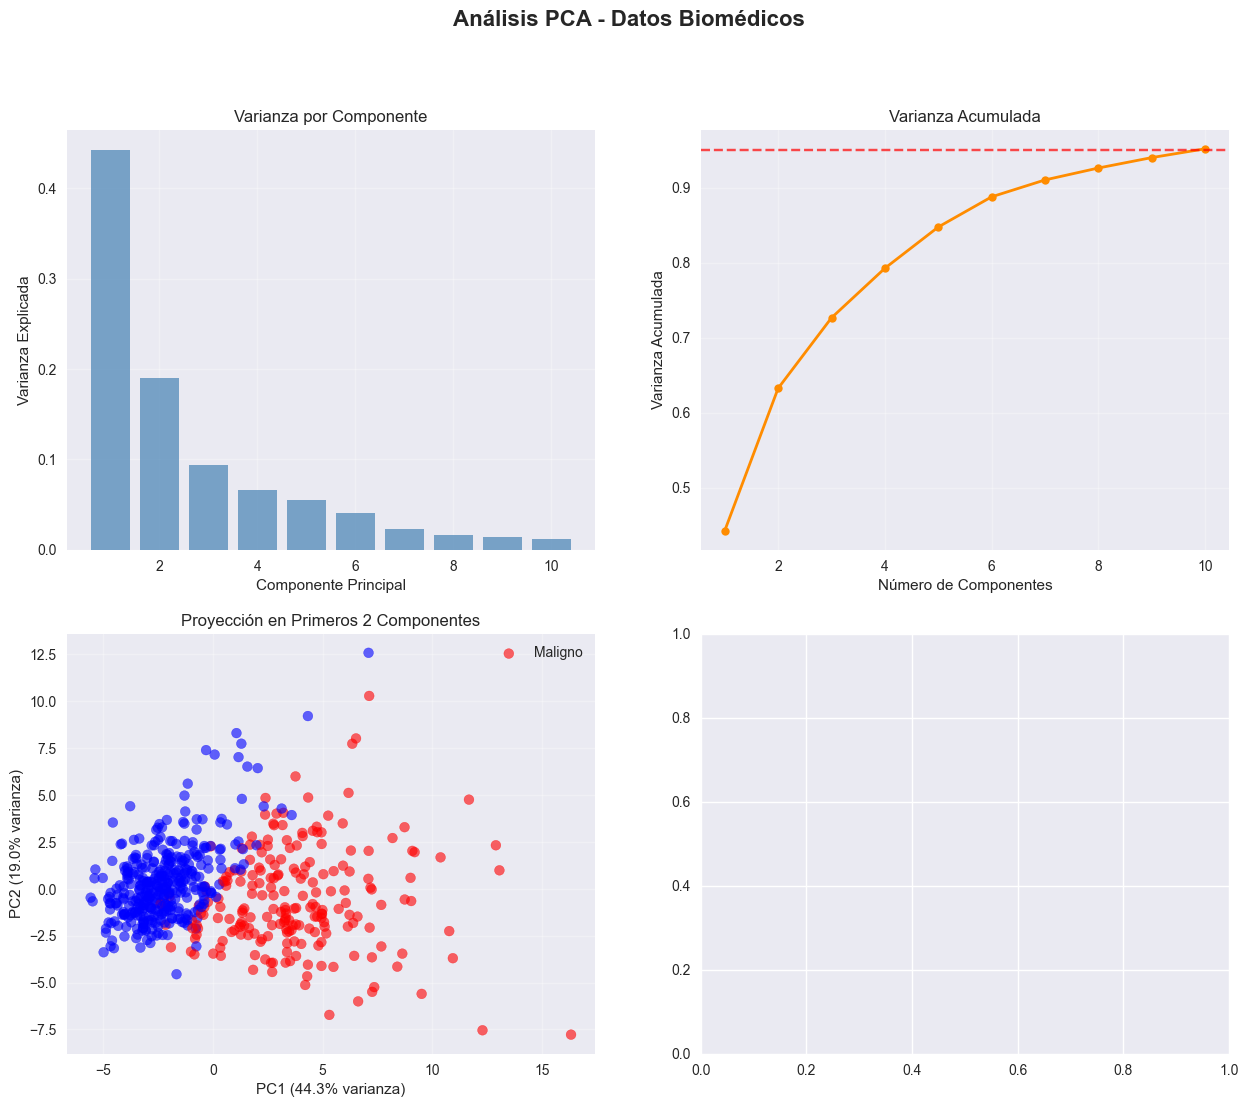

In [ ]:
# Importar librerías necesarias 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn.datasets import load_breast_cancer 

# Configurar estilo de gráficos 
plt.style.use('seaborn-v0_8') 
sns.set_palette("husl") 
print("🔬 Análisis PCA para Datos Biomédicos") 
print("="*50)

# 1. CARGAR Y PREPARAR DATOS 
# Usaremos el dataset de cáncer de mama de Wisconsin (569 muestras, 30 características) 
df = pd.read_csv("Datos_G2.csv") 
data = load_breast_cancer() 
X = data.data 
y = data.target 
feature_names = columns_interes
target_names = [df[col].unique() for col in columns_interes]

# Crear DataFrame para mejor manejo 

df.dropna(inplace=True)  # Asegurarse de no tener valores faltantes
print(f"📊 Dataset: {len(df)} muestras, {len(columns_interes)} características") 
print(f"📈 Características: {', '.join(feature_names[:5])}...") 
print(f"🎯 Clases: {target_names}")

# 2. NORMALIZACIÓN DE DATOS 
# PCA es sensible a la escala, por eso normalizamos 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
print("\n🔧 Datos normalizados (media=0, std=1)") 
print(f"Media después de normalización: {np.mean(X_scaled):.6f}") 
print(f"Desviación estándar: {np.std(X_scaled):.6f}")

# 3. APLICAR PCA 
# Inicializar PCA para conservar 95% de la varianza 
pca = PCA(n_components=0.95) 
# Mantener 95% de varianza explicada 

X_pca = pca.fit_transform(X_scaled) 
print(f"\n🧮 PCA Resultados:") 
print(f"Componentes necesarios para 95% varianza: {pca.n_components_}") 
print(f"Reducción dimensional: {X.shape[1]} → {X_pca.shape[1]}") 
print(f"Varianza explicada total: {pca.explained_variance_ratio_.sum():.3f}")

# 4. ANÁLISIS DE COMPONENTES PRINCIPALES 
# Varianza explicada por cada componente 

explained_var = pca.explained_variance_ratio_ 
cumulative_var = np.cumsum(explained_var) 
# Mostrar primeros 5 componentes 
print(f"\n📊 Varianza explicada por componente:") 
for i in range(min(5, len(explained_var))): 
    print(f"PC{i+1}: {explained_var[i]:.3f} ({explained_var[i]*100:.1f}%)") 
    print(f"\n📈 Varianza acumulada primeros 3 PCs: {cumulative_var[2]:.3f}")

# 5. VISUALIZACIÓN
# Configurar subplot 
fig, axes = plt.subplots(2, 2, figsize=(15, 12)) 
fig.suptitle('Análisis PCA - Datos Biomédicos', fontsize=16, fontweight='bold') 
# 1. Varianza explicada 
axes[0,0].bar(range(1, min(11, len(explained_var)+1)), explained_var[:min(10, len(explained_var))], alpha=0.7, color='steelblue') 
axes[0,0].set_xlabel('Componente Principal') 
axes[0,0].set_ylabel('Varianza Explicada') 
axes[0,0].set_title('Varianza por Componente') 
axes[0,0].grid(True, alpha=0.3) 
# 2. Varianza acumulada 
axes[0,1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'o-', color='darkorange', linewidth=2, markersize=6) 
axes[0,1].axhline(y=0.95, color='red', linestyle='--', alpha=0.7) 
axes[0,1].set_xlabel('Número de Componentes') 
axes[0,1].set_ylabel('Varianza Acumulada') 
axes[0,1].set_title('Varianza Acumulada') 
axes[0,1].grid(True, alpha=0.3) 
# 3. Proyección 2D (PC1 vs PC2) 
colors = ['red' if label == 0 else 'blue' for label in y] 
axes[1,0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, s=50) 
axes[1,0].set_xlabel(f'PC1 ({explained_var[0]:.1%} varianza)') 
axes[1,0].set_ylabel(f'PC2 ({explained_var[1]:.1%} varianza)') 
axes[1,0].set_title('Proyección en Primeros 2 Componentes') 
axes[1,0].legend(['Maligno', 'Benigno']) 
axes[1,0].grid(True, alpha=0.3) 
# 4. Heatmap de componentes principales 
# Mostrar contribution de variables originales a primeros 3 PCs 
components_df = pd.DataFrame( pca.components_[:3], columns=feature_names, index=['PC1', 'PC2', 'PC3'] ) 
# Seleccionar top 10 características más importantes 
importance = np.abs(components_df).sum(axis=0).sort_values(ascending=False) 
top_features = importance.head(10).index 
sns.heatmap(components_df[top_features], annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1,1], cbar_kws={'shrink': 0.8}) 
axes[1,1].set_title('Contribución de Variables a PCs') 
axes[1,1].set_xlabel('Características Principales') 
plt.tight_layout() 
plt.show()